
# Outline

- Racap of data
- Feedforward network with PyTorch tensors and autograd
- Using PyTorch's NN-> Functional, linear, sequential & PyTorch's optimizers
- Moving things to CUDA

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import math
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
from tqdm import tqdm_notebook
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

%matplotlib inline



In [5]:
torch.manual_seed(0)

In [6]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# Generate dataset

In [7]:
data, labels = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


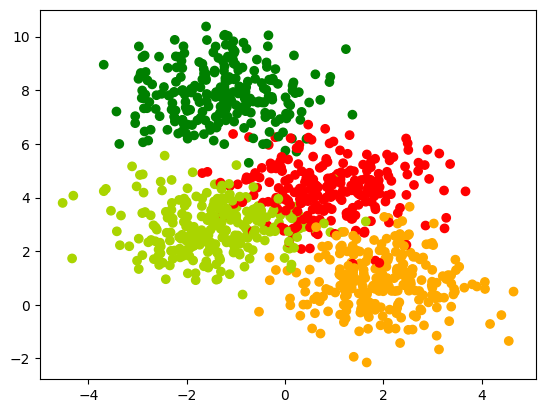

In [9]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape, labels.shape)

(750, 2) (250, 2) (750,) (250,) (1000,)


# Using torch tensors  and autograd

In [14]:
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
print(X_train.shape, Y_train.shape)

torch.Size([750, 2]) torch.Size([750])


In [16]:
a = torch.randn(2, 4)
print(a)
print("------------------")
print(a.exp())
print("------------------")
print(a.exp().sum(-1))
print("------------------")
print(a.exp().sum(-1).shape)
print("------------------")
print(a.exp().sum(-1).unsqueeze(-1))
print("------------------")
print(a.exp().sum(-1).unsqueeze(-1).shape)
print("------------------")
print(a.exp() / a.exp().sum(-1).unsqueeze(-1))

tensor([[-0.7193, -0.4033, -0.5966,  0.1820],
        [-0.8567,  1.1006, -1.0712,  0.1227]])
------------------
tensor([[0.4871, 0.6681, 0.5507, 1.1997],
        [0.4246, 3.0060, 0.3426, 1.1305]])
------------------
tensor([2.9055, 4.9037])
------------------
torch.Size([2])
------------------
tensor([[2.9055],
        [4.9037]])
------------------
torch.Size([2, 1])
------------------
tensor([[0.1677, 0.2299, 0.1895, 0.4129],
        [0.0866, 0.6130, 0.0699, 0.2305]])


In [17]:
def model(x):
  a1 = torch.matmul(x, weights1) + bias1 # (N, 2) x (2, 2) -> (N, 2)
  h1 = a1.sigmoid() # (N, 2)
  a2 = torch.matmul(h1, weights2) + bias2 # (N, 2) x (2, 4) -> (N, 4)
  h2 = a2.exp() / a2.exp().sum(-1).unsqueeze(-1) # (N, 4)
  return h2

In [27]:
y_hat = torch.tensor([[0.1, 0.2,0.3, 0.4], [0.8, 0.1 , 0.05, 0.05]])
y = torch.tensor([2,0])

(-y_hat[range(y_hat.shape[0]), y].log()).mean().item()


(torch.argmax(y_hat, dim=1) == y).float().mean().item()

0.5

In [18]:
def loss_fn (y_hat, y):
  return -(y_hat[range(y.shape[0]), y].log()).mean()

In [19]:
def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  return (pred == y).float().mean()

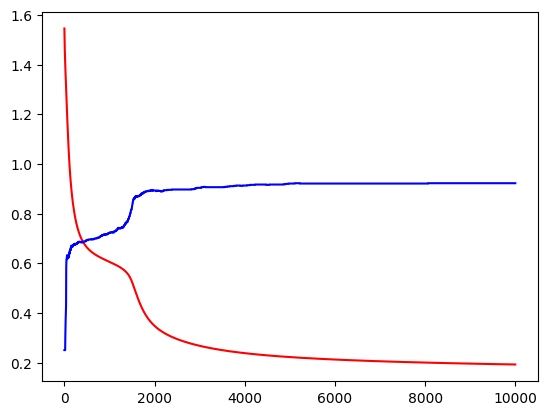

Loss before training 1.5456440448760986
Loss after training 0.19288595020771027
Accuracy after training tensor(0.9227)


In [28]:
torch.manual_seed(0)
weights1 = torch.randn(2, 2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

X_train = X_train.float()
Y_train = Y_train.long()

loss_arr = []
acc_arr = []

for epoch in range(epochs):
  y_hat = model(X_train)
  loss = loss_fn(y_hat, Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat, Y_train))

  with torch.no_grad():
    weights1 -= weights1.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    weights1.grad.zero_()
    bias1.grad.zero_()
    weights2.grad.zero_()
    bias2.grad.zero_()



plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])
print('Accuracy after training', acc_arr[-1])


# Using NN.Functional

In [29]:
import torch.nn.functional as F

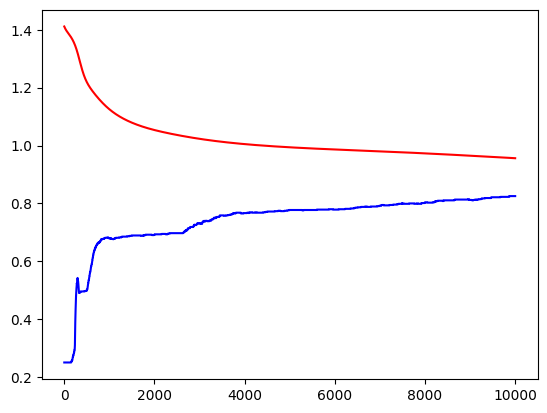

Loss before training 1.4111982583999634
Loss after training 0.9561846256256104
Accuracy after training tensor(0.8253)


In [30]:
torch.manual_seed(0)
weights1 = torch.randn(2, 2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

X_train = X_train.float()
Y_train = Y_train.long()

loss_arr = []
acc_arr = []

for epoch in range(epochs):
  y_hat = model(X_train)
  loss = F.cross_entropy(y_hat, Y_train) #loss_fn(y_hat, Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat, Y_train))

  with torch.no_grad():
    weights1 -= weights1.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    weights1.grad.zero_()
    bias1.grad.zero_()
    weights2.grad.zero_()
    bias2.grad.zero_()



plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])
print('Accuracy after training', acc_arr[-1])


# Using NN.Parameter

In [31]:
import torch.nn as nn

In [32]:
class FirstNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.weights1 = nn.Parameter(torch.randn(2, 2) / math.sqrt(2))
    self.bias1 = nn.Parameter(torch.zeros(2))
    self.weights2 = nn.Parameter(torch.randn(2, 4) / math.sqrt(2))
    self.bias2 = nn.Parameter(torch.zeros(4))

  def forward(self, X):
    a1 = torch.matmul(X, self.weights1) + self.bias1 # (N, 2) x (2, 2) -> (N, 2)
    h1 = a1.sigmoid() # (N, 2)
    a2 = torch.matmul(h1, self.weights2) + self.bias2 # (N, 2) x (2, 4) -> (N, 4)
    h2 = a2.exp() / a2.exp().sum(-1).unsqueeze(-1) # (N, 4)
    return h2

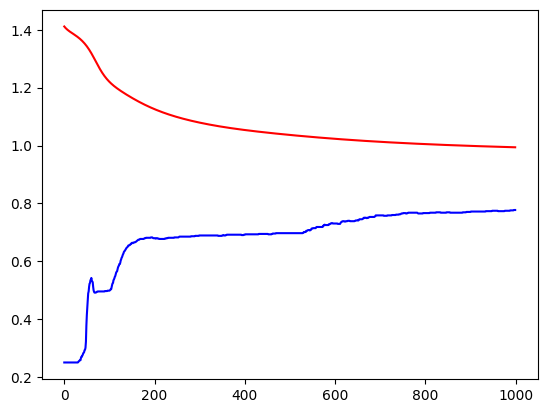

Loss before training 1.4111982583999634
Loss after training 0.9939236044883728
Accuracy after training 0.7773333191871643


In [37]:
def fit(fn, X_train, Y_train, epochs=1000, learning_rate=1):
    loss_arr = []
    acc_arr = []
    for epoch in range(epochs):
        y_hat = fn(X_train)
        loss = F.cross_entropy(y_hat, Y_train)
        loss.backward()
        loss_arr.append(loss.item())

        with torch.no_grad():
            for param in fn.parameters():
                param -= learning_rate * param.grad
            fn.zero_grad()

        # Compute accuracy
        predicted_classes = torch.argmax(y_hat, dim=1)
        accuracy = (predicted_classes == Y_train).float().mean().item()
        acc_arr.append(accuracy)

    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])
    print('Accuracy after training', acc_arr[-1])

# Create an instance of the FirstNetwork model
fn = FirstNetwork()

# Call fit function with the model instance and training data
fit(fn, X_train, Y_train)


# Using NN.Linear and Optim

In [39]:
class FFNetwork_v1(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.lin1 = nn.Linear(2, 2)
    self.lin2 = nn.Linear(2, 4)

  def forward(self, X):
    a1 = self.lin1(X)
    h1 = a1.sigmoid()
    a2 = self.lin2(h1)
    h2 = a2.exp() / a2.exp().sum(-1).unsqueeze(-1)
    return h2

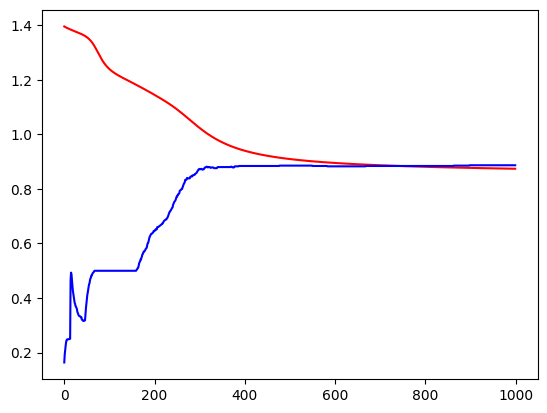

Loss before training 1.3951597213745117
Loss after training 0.8738412857055664
Accuracy after training 0.8866666555404663


In [40]:
def fit_v1(model, X_train, Y_train, epochs=1000, learning_rate=1):
    loss_arr = []
    acc_arr = []
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        y_hat = model(X_train)
        loss = criterion(y_hat, Y_train)
        loss.backward()
        optimizer.step()

        loss_arr.append(loss.item())

        # Compute accuracy
        _, predicted_classes = torch.max(y_hat, 1)
        accuracy = (predicted_classes == Y_train).float().mean().item()
        acc_arr.append(accuracy)

    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])
    print('Accuracy after training', acc_arr[-1])

# Create an instance of the FFNetwork_v1 model
model_v1 = FFNetwork_v1()

# Convert the data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

# Call fit function with the model instance and training data
fit_v1(model_v1, X_train_tensor, Y_train_tensor)


# Using NN.Sequential

In [42]:
class FFNetwork_v2(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
      nn.Linear(2, 2),
      nn.Sigmoid(),
      nn.Linear(2, 4),
      nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

In [48]:
def fit_v2(model, X_train, Y_train, loss_fn, opt, epochs=1000):
    for epoch in range(epochs):
        loss = loss_fn(model(X_train), Y_train)
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item()






In [49]:
fn = FFNetwork_v2()
loss_fn = F.cross_entropy
opt = torch.optim.SGD(fn.parameters(), lr=0.2)

fit_v2(fn, X_train, Y_train, loss_fn, opt, epochs=1000)



1.1441876888275146

# Migrating it to CUDA

# Running it on GPUs

In [50]:
device = torch.device('cpu')

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn.to(device)
tic = time.time()
print(" Final loss", fit_v2(fn, X_train, Y_train, loss_fn, opt, epochs=1000))
toc = time.time()
print("Time taken", toc - tic)

 Final loss 0.9404546618461609
Time taken 1.670285701751709


In [52]:
# device = torch.device('cuda')

# X_train = X_train.to(device)
# Y_train = Y_train.to(device)
# fn.to(device)
# tic = time.time()
# print(" Final loss", fit_v2(fn, X_train, Y_train, loss_fn, opt, epochs=1000))
# toc = time.time()
# print("Time taken", toc - tic)

In [53]:
class FFNetwork_v3(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
      nn.Linear(2, 128),
      nn.Sigmoid(),
      nn.Linear(128, 4),
      nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

In [54]:
device = torch.device('cpu')

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FFNetwork_v3()
fn.to(device)
tic = time.time()
print(" Final loss", fit_v2(fn, X_train, Y_train, loss_fn, opt, epochs=1000))
toc = time.time()
print("Time taken", toc - tic)

 Final loss 1.398587942123413
Time taken 1.633626937866211


In [55]:
# device = torch.device('cuda')

# X_train = X_train.to(device)
# Y_train = Y_train.to(device)
# fn = FFNetwork_v3()
# fn.to(device)
# tic = time.time()
# print(" Final loss", fit_v2(fn, X_train, Y_train, loss_fn, opt, epochs=1000))
# toc = time.time()
# print("Time taken", toc - tic)

# Exercises

- Try out a deeper neural network , e.g. hidden layers of size 100
- Try out a different parameters in the optimizer(e. g. try momentum, nesterov etc.) -> check optim.SGD docs
- Try out a other opitmaization algorithm(e.g. Adam, RMSprop etc.) which are supported in optim.
- Try out a different initialization technique which are supported in nn.init